<a href="https://colab.research.google.com/github/ankitbatra22/Gesture-Recognizer/blob/develop/gesture_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from preprocessing import VideoFolder
import json
from torchvision.transforms import *
import cv2
from PIL import Image as im
from matplotlib import pyplot as plt
from model import Net
import torch.optim as optim
import os
import tqdm
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip '/content/drive/MyDrive/20bn-jester-v1.zip'

Archive:  /content/drive/MyDrive/20bn-jester-v1.zip
replace __MACOSX/._20bn-jester-v1? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [79]:
import json
import os

with open("./configs/config.json") as dataFile:
  config = json.load(dataFile)

save_dir = os.path.join(config["output_dir"], config["model_name"])

transform = Compose([
        #CenterCrop(100),
        #Resize(size=(300,300)),
        ToTensor()
        #Normalize(mean=[0.485, 0.456, 0.406],
                  #std=[0.229, 0.224, 0.225])
    ])

In [80]:
train_data = VideoFolder(root=config['train_data_folder'],
                             csv_file_input=config['train_data_csv'],
                             csv_file_labels=config['labels_csv'],
                             clip_size=config['clip_size'],
                             nclips=1,
                             step_size=config['step_size'],
                             is_val=False,
                             transform=transform,
                             )

train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=config['batch_size'], shuffle=True,
        num_workers=config['num_workers'], pin_memory=True,
        drop_last=True)
  
val_data = VideoFolder(root=config['val_data_folder'],
                          csv_file_input=config['val_data_csv'],
                          csv_file_labels=config['labels_csv'],
                          clip_size=config['clip_size'],
                          nclips=1,
                          step_size=config['step_size'],
                          is_val=True,
                          transform=transform,
                          )

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=config['batch_size'], shuffle=False,
    num_workers=config['num_workers'], pin_memory=True,
    drop_last=False)

In [75]:
device = (torch.device('cuda') if torch.cuda.is_available()
else torch.device('cpu'))
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

net = Net()
optimizer = torch.optim.SGD(net.parameters(), config['lr'],
                                momentum=config['momentum'],
                                weight_decay=config['weight_decay'])

criterion = nn.CrossEntropyLoss(reduction='sum')
EPOCHS = 1

Tesla P100-PCIE-16GB
True


tensor(3)


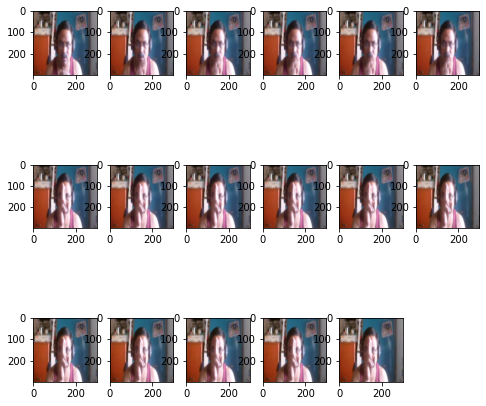

In [82]:
x = next(iter(val_loader))

NUM = 15

print(x[1][NUM])
vidBatch = (x[0][NUM])
pog = vidBatch.permute(1,2,3,0)
pog[0]

import numpy as np
import matplotlib.pyplot as plt

w = 12
h = 12
fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 3

for i in range(1, columns*rows):
    #img = np.random.randint(10, size=(h,w))
    img = pog[i].detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()



EPOCH:  0
0
20
22
26
21
21
23
22
23
26
21
27
22
24
21
23
24
23
25
20
18
25
19
24
23
24
21
22
21
25
26
19
23
25
23
24
25
23
23
27
20
26
20
21
27
20
26
24
23
26
23
23
25
24
28
26
19
22
26
24
22
25
27
22
27
24
27
24
22
23
27
19
27
25
24
26
23
25
26
26
25
24
25
27
23
22
21
25
23
23
25
25
24
20
22
25
24
22
23
26
22
25
17
27
24
25
27
21
20
24
22
17
26
26
25
24
24
22
23
27
22
22
19
24
24
27
22
25
27
23
27
23
25
22
25
20
20
23
22
22
24
23
20
25
17
28
26
25
22
26
25
24
26
22
28
25
23
26
19
22
25
22
23
21
22
23
25
26
27
25
24
24
23
26
22
26
24
21
16
22
23
20
24
25
24
24
25
25
24
27
23
24
26
25
29
24
25
27
23
24
22
25
24
21
23
20
24
25
27
27
20
4
4960 6752
TRAIN LOSS:  0.015638363077700175 VALIDATION LOSS: 28.727190080977163
VALIDATION ACCURACY 0.7345971563981043


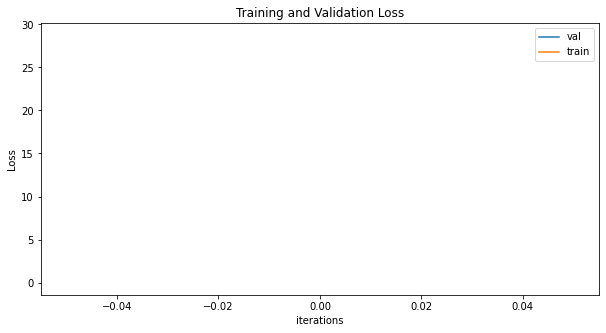

In [37]:
import matplotlib.pyplot as plt


net.cuda()

val_losses = []
train_losses = []
min_valid_loss = 1e99
correct, total = 0, 0


for epoch in range(EPOCHS):
    train_loss = 0.0
    net.train()

    print("EPOCH: ", epoch)
    for i, (input, target) in enumerate(train_loader):
      print(i)
      input, target = input.to(device = device), target.to(device = device)
      net.zero_grad()
      output = net(input)
      loss = criterion(output, target)
      train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #print("LOSS", loss / 32)
      break

    net.eval()
    validation_loss = 0.0


    with torch.no_grad():
      for i, (item, truth) in enumerate(val_loader):
        item, truth = item.to(device = device), truth.to(device = device)
        out = net(item)
        #print(torch.argmax(out, dim=1), truth)
        # [predictions] and [truth]
        matching = torch.eq(torch.argmax(out, dim=1), truth)
        print(torch.sum(matching, dim=0).item())
        # [boolean array]
        correct += torch.sum(matching, dim=0).item()
        total += 32
        valLoss = criterion(out, truth)
        validation_loss += valLoss.item()

    print(correct, total)
    accuracy = correct / total
        

    validation_loss /= len(val_loader)
    train_loss /= len(train_loader)
    
    if validation_loss < min_valid_loss:
      min_valid_loss = validation_loss
      torch.save(net.state_dict(), '/content/drive/MyDrive/weights.pt')
      
    train_losses.append(train_loss)
    val_losses.append(validation_loss)

    print("TRAIN LOSS: ", train_loss, "VALIDATION LOSS:", validation_loss)
    print("VALIDATION ACCURACY", accuracy)



plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

